In [1]:
import re
import string
import pandas as pd
from math import log
from functools import reduce
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_20newsgroups
from mpl_toolkits.mplot3d import Axes3D
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.mixture import GaussianMixture


### Collecting dataset - 3 news grops from 20newsgroups:

In [2]:
categories = ['alt.atheism', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)

### Preprocessing and vectorizing:

### Подготовим два векторных представления  полученных данных (tfidf и мешок слов)

In [3]:
def preprocessing(line):
    line = line.lower()
    line = re.sub(r"[{}]".format(string.punctuation), " ", line)
    return line

In [4]:
tfidf_vectorizer = TfidfVectorizer(preprocessor=preprocessing, stop_words="english", max_df=0.95, min_df=2)
tfidf = tfidf_vectorizer.fit_transform(newsgroups_train.data, newsgroups_train.target)
print(tfidf.shape)

bag_of_words_vectorizer = CountVectorizer(preprocessor=preprocessing, stop_words="english", max_df=0.95, min_df=2,)
bag_of_words = bag_of_words_vectorizer.fit_transform(newsgroups_train.data, newsgroups_train.target)
print(bag_of_words.shape)

(1657, 14729)
(1657, 14729)


##  Изобразим получившиеся вектора с помощью трёх методов понижения размерности (PCA, MDS, TSNE)

In [7]:
def show(figure, model, X, Y):
    plt.figure(0, figsize=(20,10))
    def calculate(X, n):
        reduced_features = model.fit_transform(X.toarray())
        plt.subplot(1, 2, n)
        plt.title(['', 'Tfidf + ', 'Bag of words + '][n] + ['PCA', 'MDS', 'TSNE'][figure])
        plt.scatter(reduced_features[:,0], reduced_features[:,1], c=newsgroups_train.target)
    calculate(X, 1)
    calculate(Y, 2)

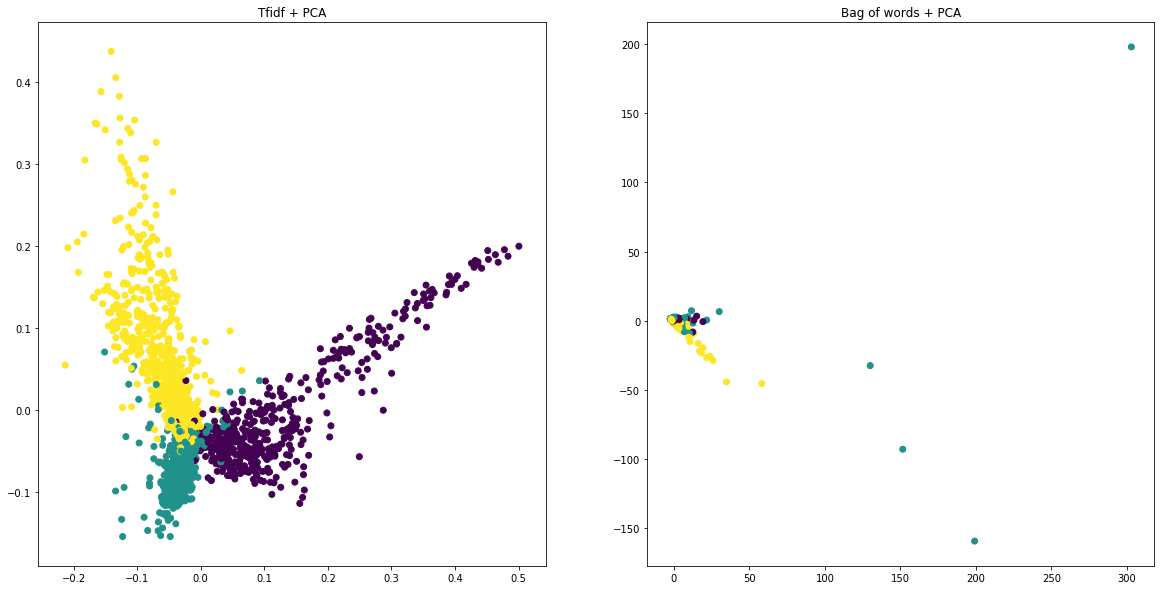

In [6]:
show(0, 0, PCA(n_components=2, random_state=42), tfidf, bag_of_words)

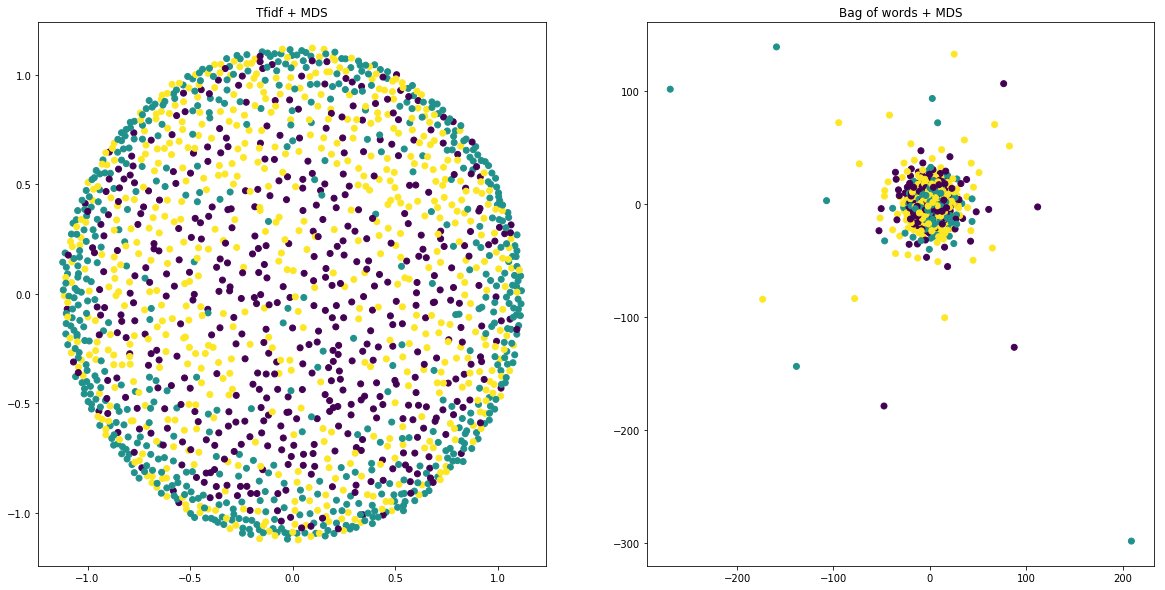

In [7]:
show(0, 1, MDS(n_components=2, random_state=42), tfidf, bag_of_words)

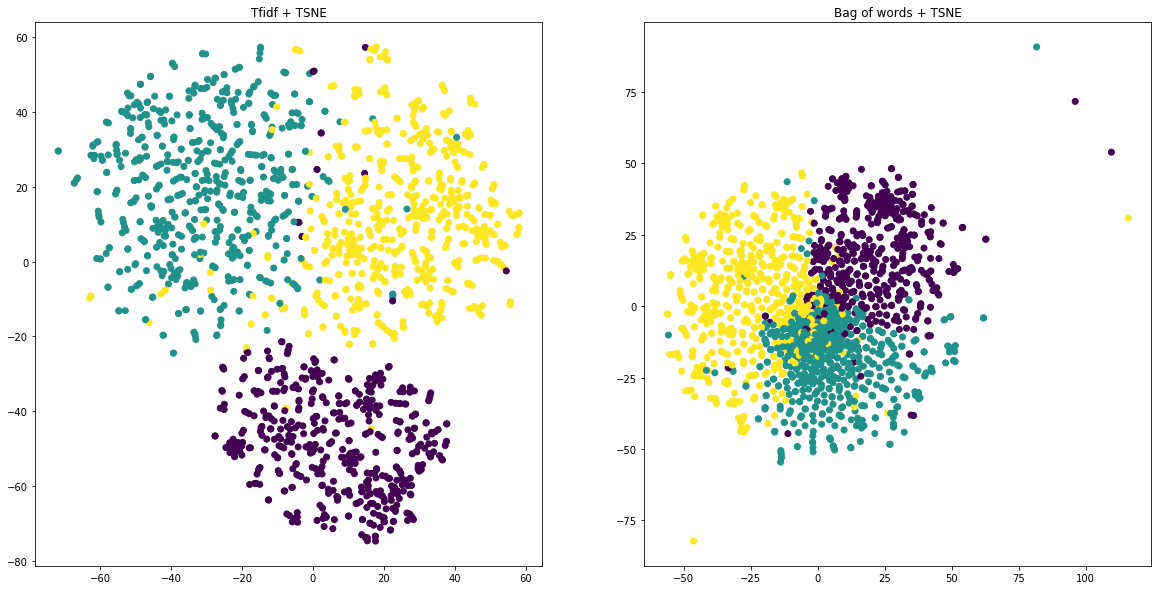

In [8]:
show(0, 2, TSNE(n_components=2, random_state=42), tfidf, bag_of_words)

### Вывод: 
* с помощью MDS трудно оценить визуальное деление на кластеры
* более наглядное деление на кластеры получилось с помощью PCA и TSNE
* во всех трёх случаях данные, представленные в виде мешка слов плохо отражают реальное разделение и , возможно, требуют дополнительной обработки
* далее будем использовать PCA и TSNE

In [10]:
def find_clusters_number(model, X, r=range(1, 7)):
    scores = {}
    for n in r:
        model.set_params(n_clusters=n)
        predicted = model.fit_predict(X.todense())
        scores[metrics.adjusted_rand_score(newsgroups_train['target'], predicted)] = n
    print(scores)
    print(f'\nBest adjusted rand score for this model - {max(scores.keys())}\nNumber of clusters - {scores[max(scores.keys())]}\n')
    return scores[max(scores.keys())]

# Agglomerative Clustering:

### Метод требует заданное число кластеров, получим его перебором, используя в качестве критерия adjusted rand score    

In [11]:
aglom_predicted = []
for X in [tfidf, bag_of_words]:
    n_clusters = find_clusters_number(AgglomerativeClustering(memory="mycachedir"), X)
    aglom = AgglomerativeClustering(n_clusters=n_clusters, memory="mycachedir")
    aglom_predicted.append(aglom.fit_predict(X.todense()))

{0.0: 1, 0.44624710877542756: 2, 0.6801029366696382: 3, 0.6378340649030533: 4, 0.619832477347615: 5, 0.5815917931954419: 6}

Best adjusted rand score for this model - 0.6801029366696382
Number of clusters - 3

{0.0: 1, -0.00021923442411326513: 2, -0.00022361830201113775: 3, -0.00022673653992032758: 4, -0.00022968181517434494: 5, -0.00020288249502011592: 6}

Best adjusted rand score for this model - 0.0
Number of clusters - 1



#### При 3 кластерах получается наилучший результат - 68% для tfidf, а для мешка слов не удалось адекватно кластеризовать при данных настройках   

In [23]:
def show_predicted(figure, method, decomp, predicted, X, Y):
    plt.figure(figure, figsize=(20,10))
    def calculate(X, n):
        reduced_features = decomp.fit_transform(X.toarray())
        plt.subplot(1, 2, n)
        plt.title(['', 'Tfidf + ', 'Bag of words + '][n] + ['PCA', 'MDS', 'TSNE'][method])
        plt.scatter(reduced_features[:,0], reduced_features[:,1], c=predicted[n-1])
    calculate(X, 1)
    calculate(Y, 2)

###  Изобразим получившиеся кластеры с помощью двух методов понижения размерности (PCA, TSNE)

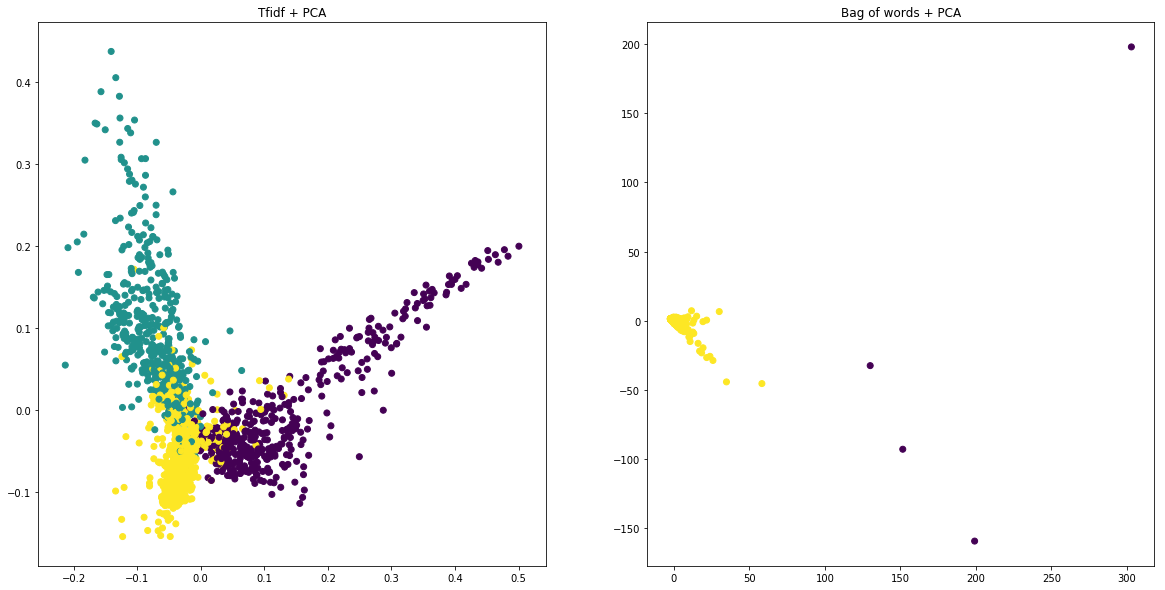

In [12]:
show_predicted(0, 0, PCA(n_components=2, random_state=42), aglom_predicted, tfidf, bag_of_words)

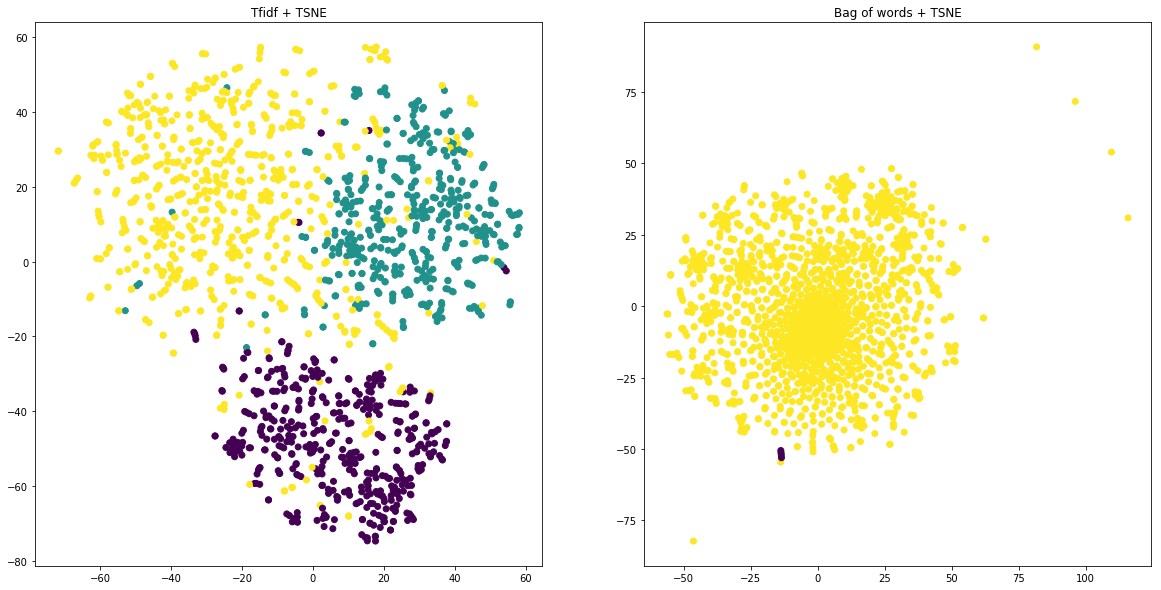

In [14]:
show_predicted(0, 2, TSNE(n_components=2, random_state=42), aglom_predicted, tfidf, bag_of_words)

## Вывод:
* алгоритм не справился с кластреризации векторов, полученных подсчётом частоты употребления (bag of words)
* для данного множества,с нечёким делением на кластеры, модель показала неплохие результаты 

# DBSCAN:

### Попробуем подобрать оптимальные параметры для этой модели (min_samples = [10, 100,500]):

In [30]:
def show_different_params_dbscan(tfidf, bag_of_words, eps=0.5, r=[10, 100, 500]):
    for n in r:
        dbscan = DBSCAN(eps=eps, min_samples=n)
        dbscan_predicted = [dbscan.fit_predict(tfidf.todense()), dbscan.fit_predict(bag_of_words.todense())]
        show_predicted(r.index(n), 0, PCA(n_components=2, random_state=42), dbscan_predicted, tfidf, bag_of_words)
    

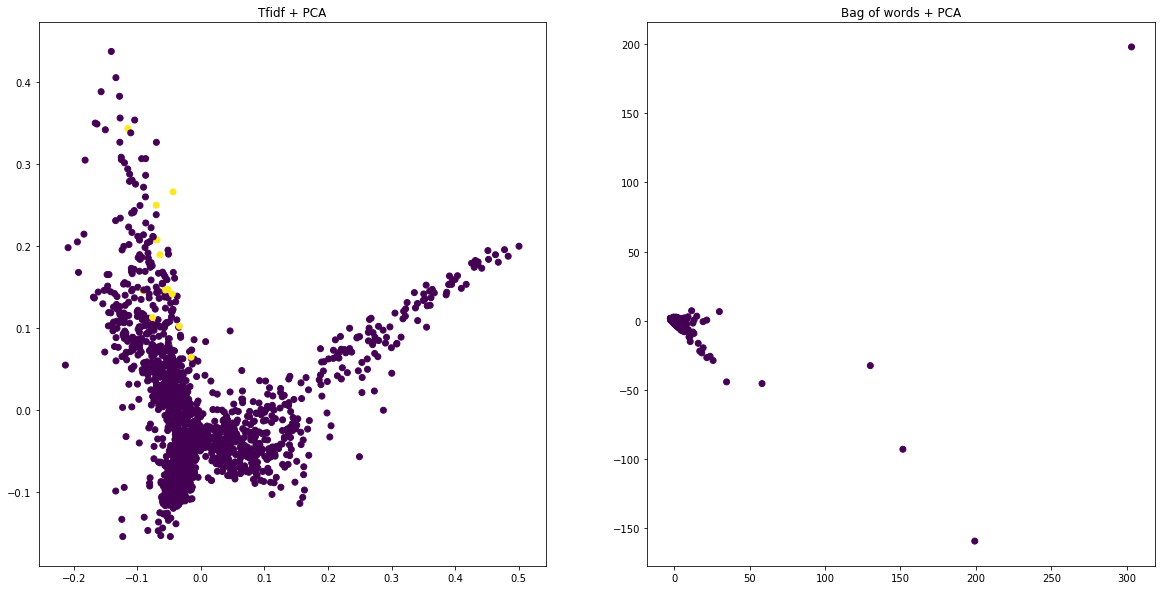

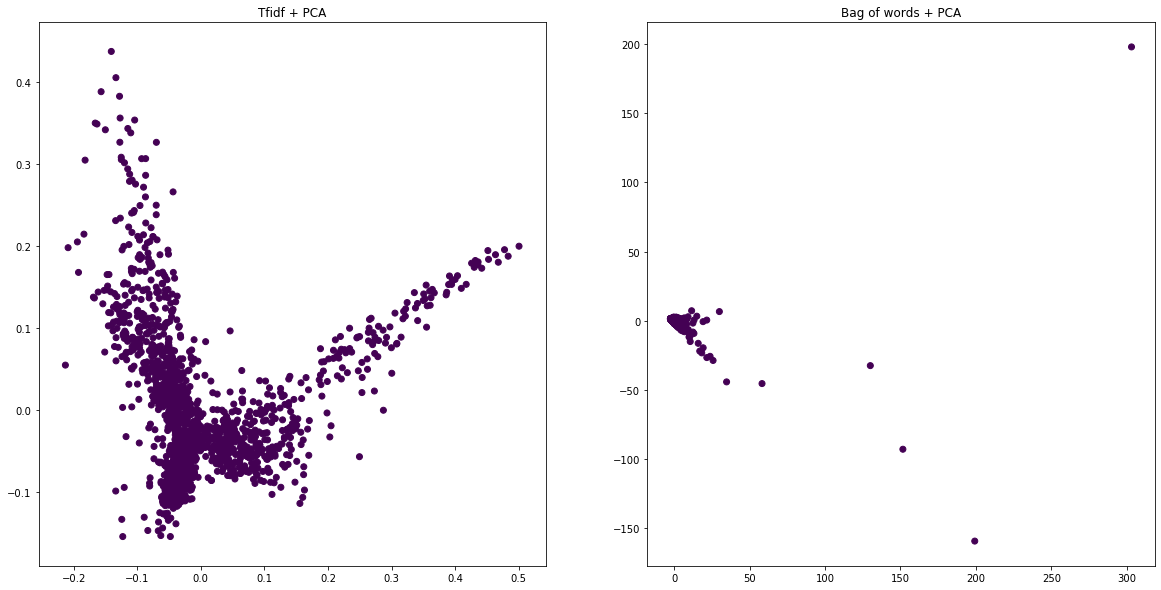

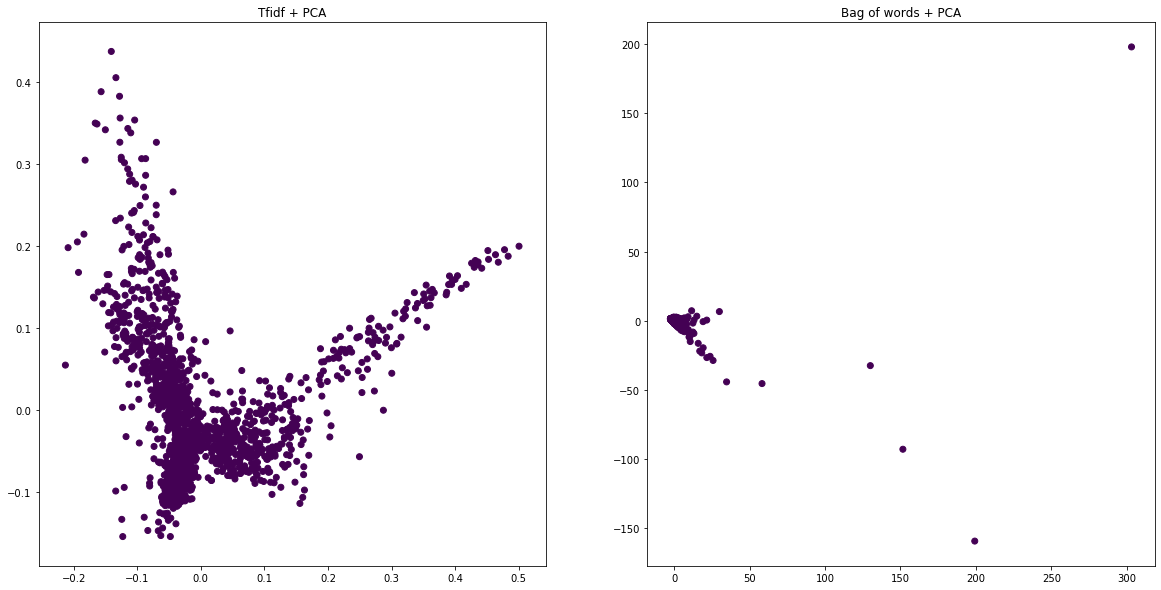

In [26]:
show_different_params_dbscan(tfidf, bag_of_words, 1)

### Не получилось, изменим eps=0.5

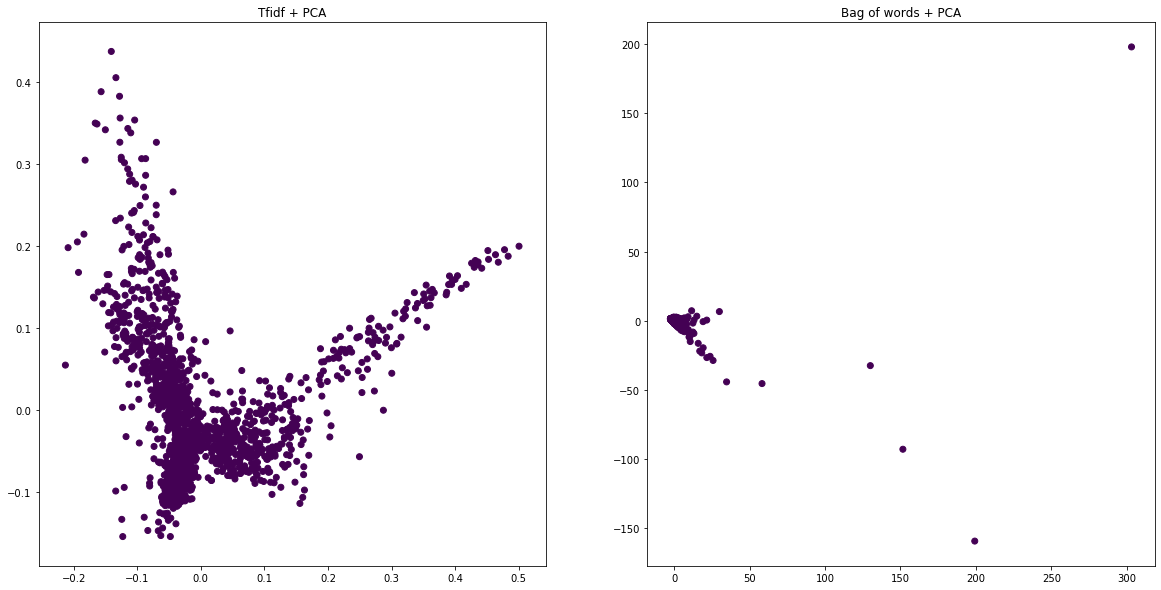

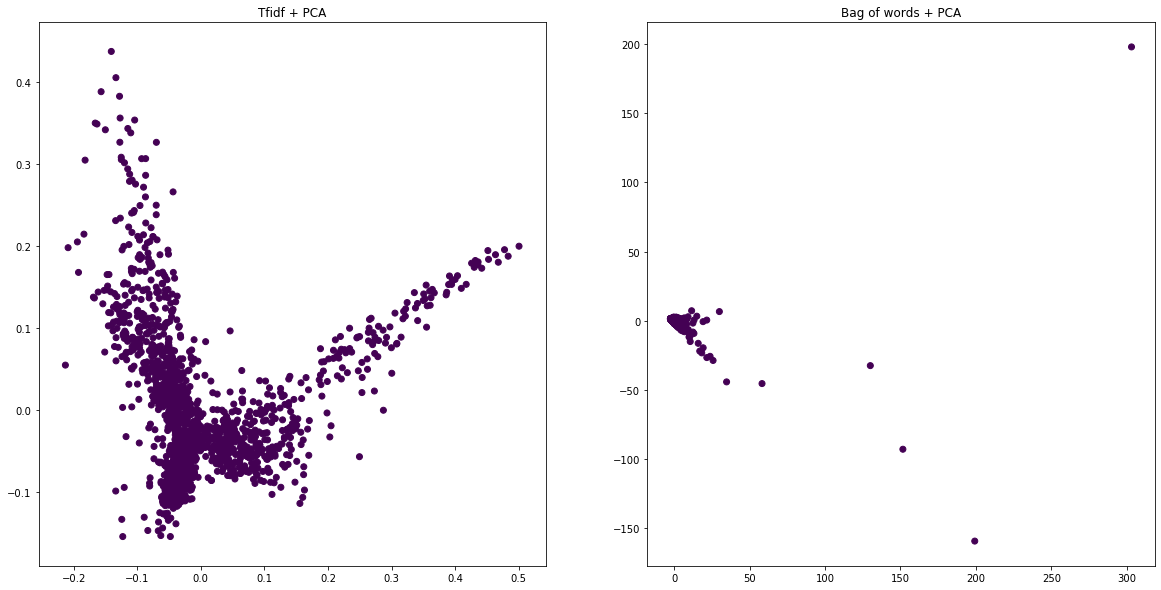

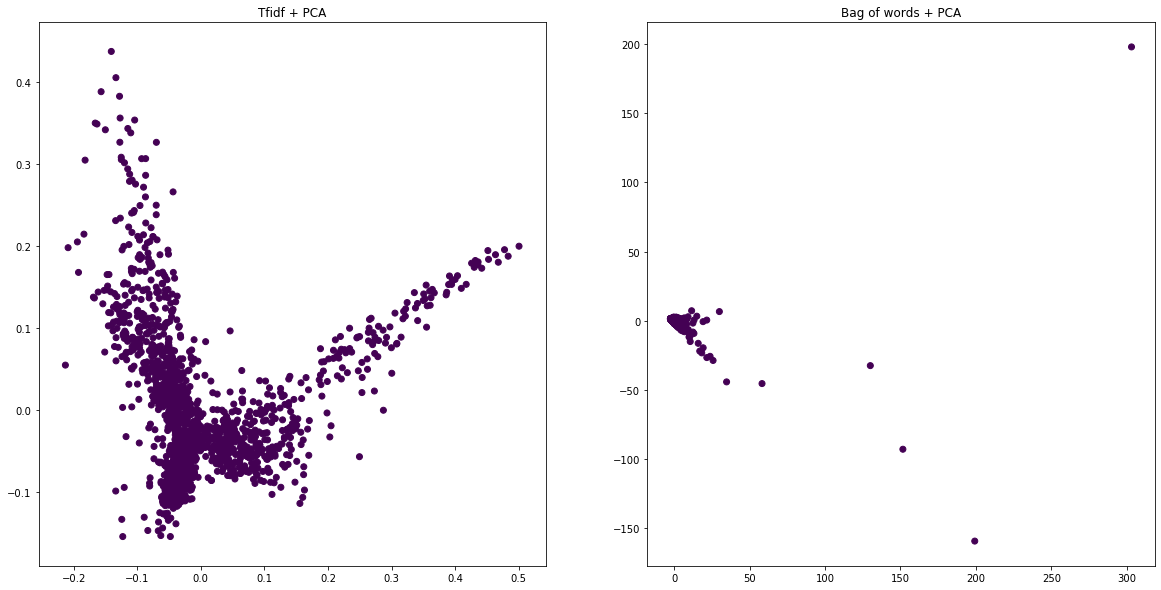

In [28]:
show_different_params_dbscan(tfidf, bag_of_words, 0.5)

### стало хуже, уменьшим min_samples до 1 и 5

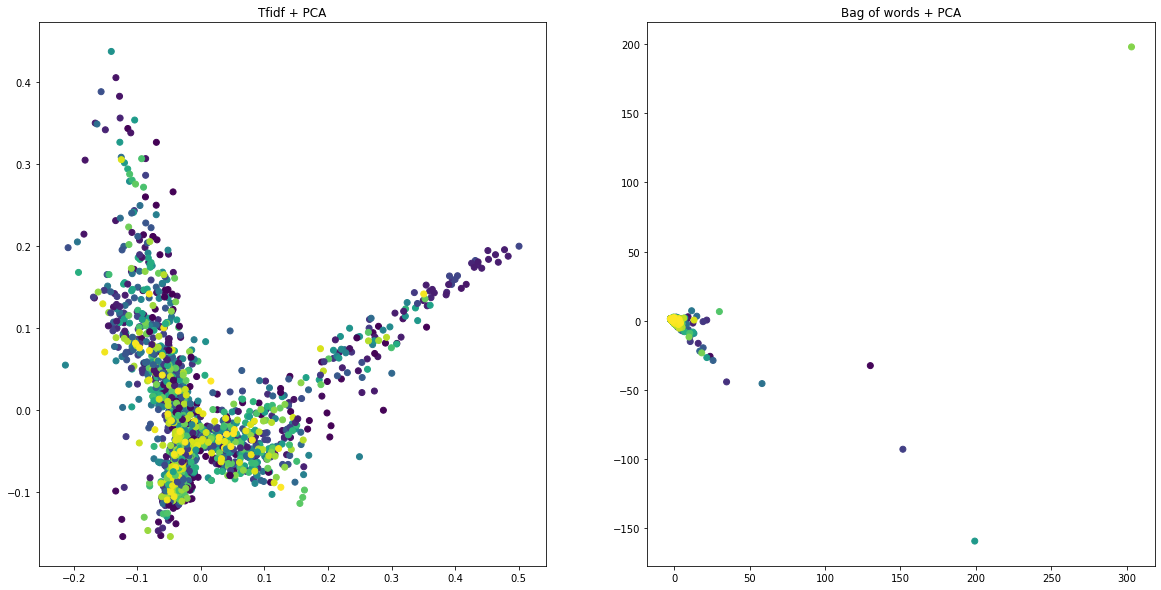

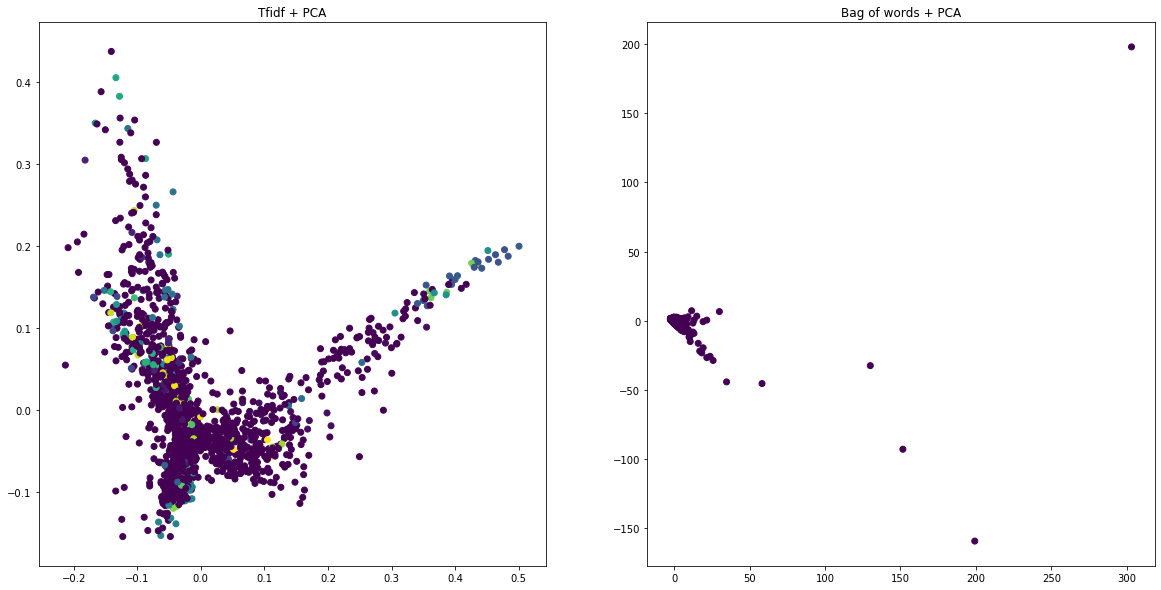

In [31]:
show_different_params_dbscan(tfidf, bag_of_words, 1, [1, 5])

### а теперь с eps = 0.8, min_samples = [2, 3, 4]

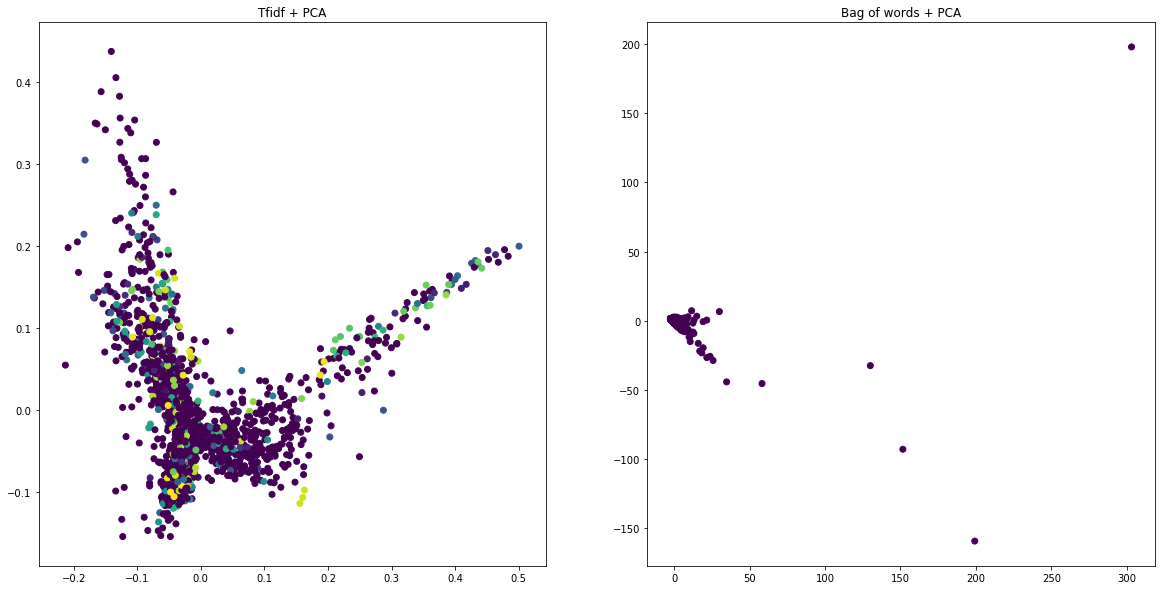

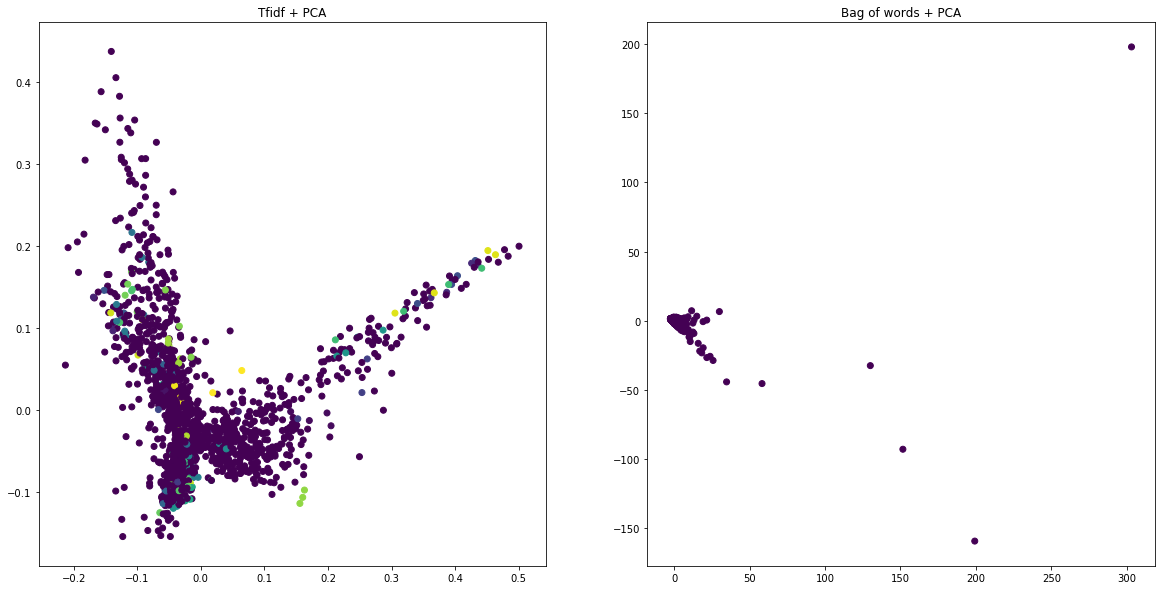

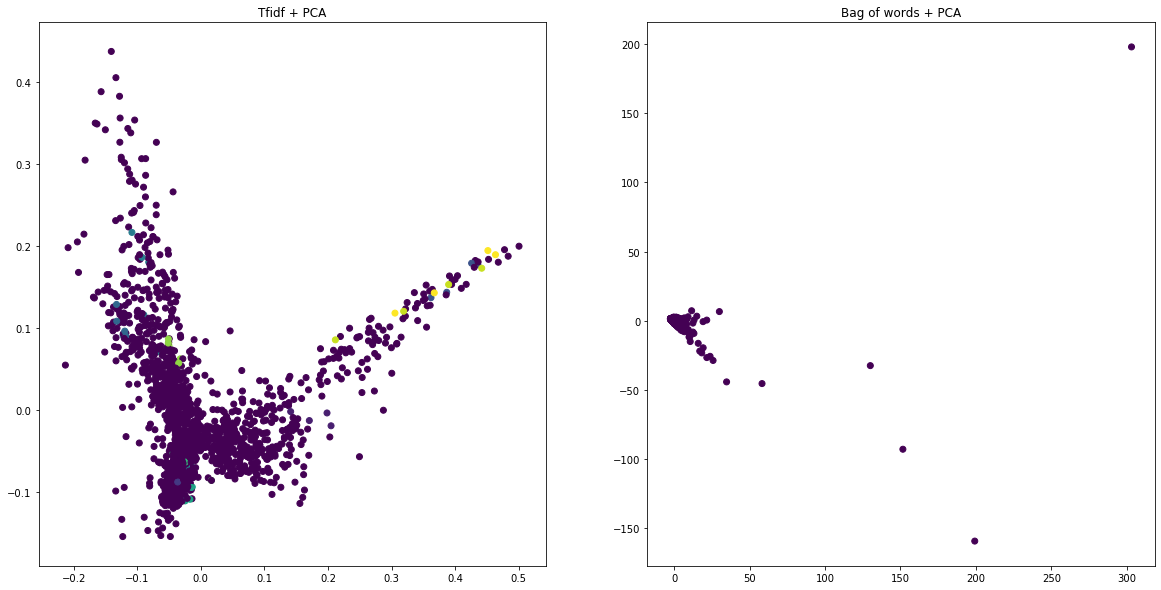

In [32]:
show_different_params_dbscan(tfidf, bag_of_words, 0.8, [2, 3, 4])

### Вывод:
* не удалось подобрать параметры для успешной кластеризации
* возможно, и не получится

# K-Means:

### Для подбора количества кластеров используем метод Elbow:

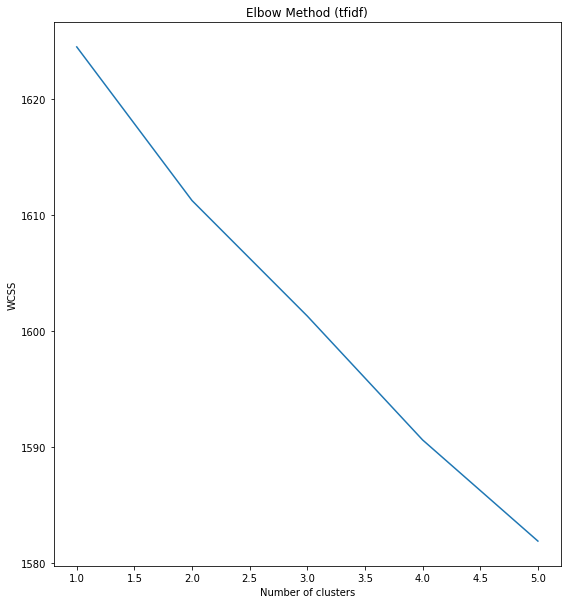

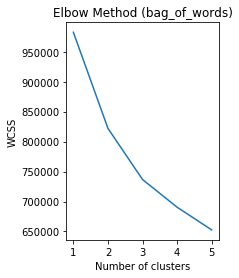

In [33]:
def elbow(tfidf, bag_of_words):
    plt.figure(0, figsize=(20,10))
    def calculate(n, X):
        wcss = []
        for n_clusters in range(1, 6):
            kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=42)
            kmeans.fit(X)
            wcss.append(kmeans.inertia_)
        plt.subplot(1, 2, n)
        plt.plot(range(1, 6), wcss)
        plt.title(f'Elbow Method ({["tfidf", "bag_of_words"][n-1]})')
        plt.xlabel('Number of clusters')
        plt.ylabel('WCSS')
        plt.show()
    calculate(1, tfidf)
    calculate(2, bag_of_words)

elbow(tfidf, bag_of_words)

### Перегиб получается при количестве кластеров равном 3 (для мешка слов, для tfidf непонятно, потому тоже будет 3)

In [35]:
## Изобразим и измерим метрику:

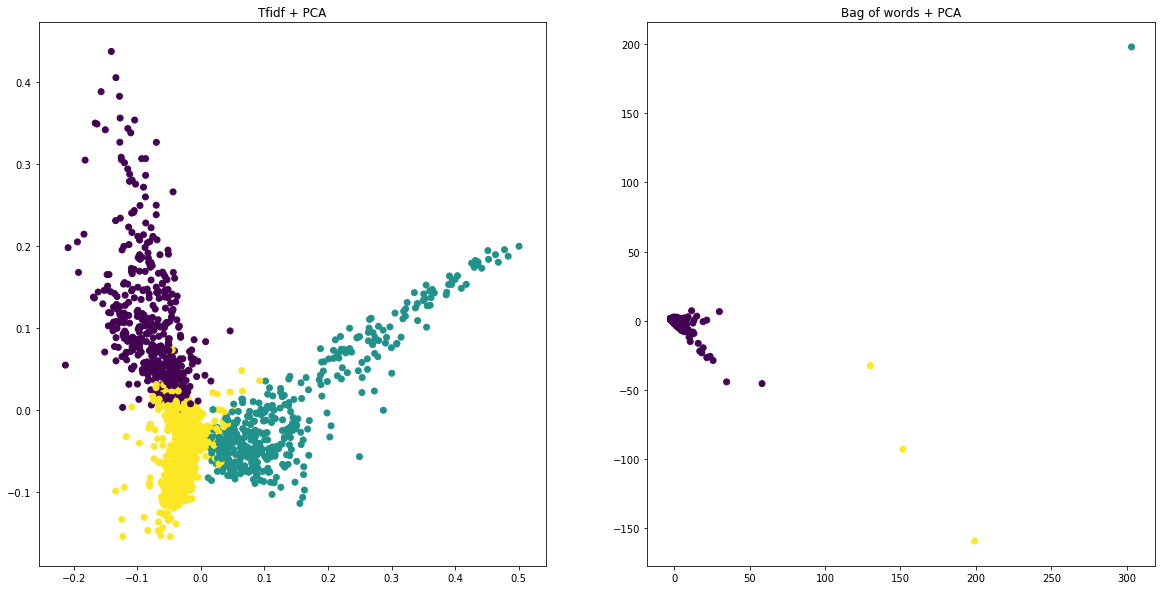

In [36]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_predicted = [kmeans.fit_predict(tfidf.todense()), kmeans.fit_predict(bag_of_words.todense())]
show_predicted(0, 0, PCA(n_components=2, random_state=42), kmeans_predicted, tfidf, bag_of_words)

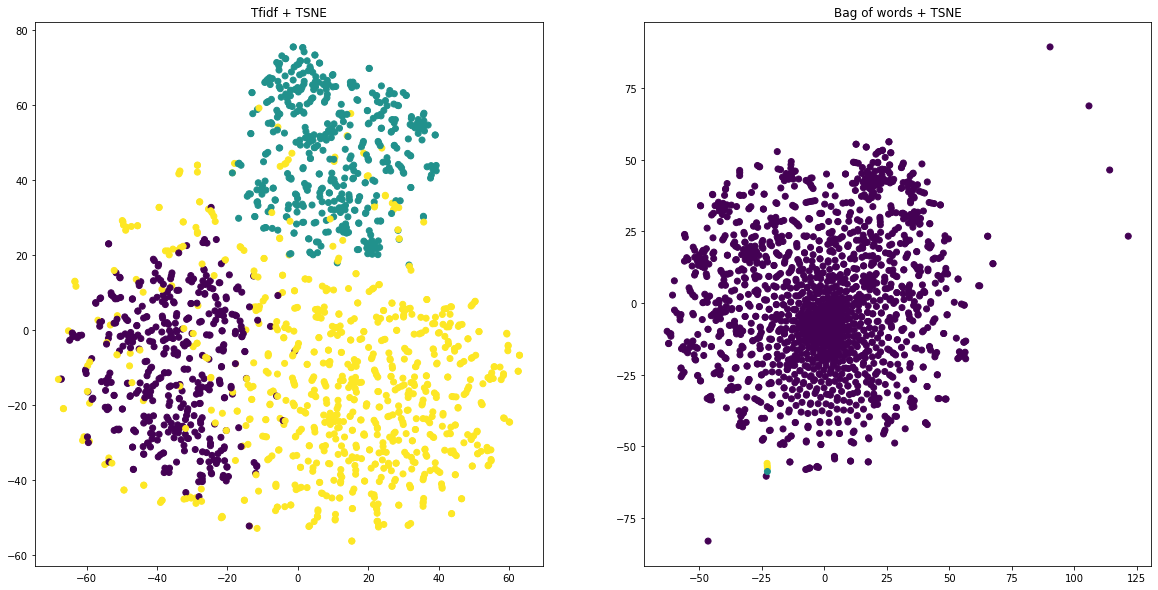

In [37]:
show_predicted(0, 2, TSNE(n_components=2, random_state=42), kmeans_predicted, tfidf, bag_of_words)

In [38]:
print(f"\nTfidf: {metrics.adjusted_rand_score(newsgroups_train['target'], kmeans_predicted[0])}")
print(f"\nBag of words: {metrics.adjusted_rand_score(newsgroups_train['target'], kmeans_predicted[1])}")


Tfidf: 0.6328790236965528

Bag of words: -0.00022361830201113775


### Вывод:

* в целом, для tfidf модель показала неплохой результат, сранимый по точности с Agglomerative Clustering

# Latent Dirichlet Allocation:

### Для подбора оптимального числа компонент LDA используем стандартный GridSearchCV

In [20]:
search_params = {'n_components': [3, 2, 4, 5]}
lda = LatentDirichletAllocation()
model = GridSearchCV(lda, param_grid=search_params)
model_tf = model.fit(tfidf)
model_bag = model.fit(bag_of_words)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [23]:
print(model_tf.best_params_)
print(model_bag.best_params_)

{'n_components': 2}
{'n_components': 2}


In [25]:
lda_tf = LatentDirichletAllocation(n_components=model_tf.best_params_['n_components'])
lda_bag = LatentDirichletAllocation(n_components=model_bag.best_params_['n_components'])
lda_tf.fit(tfidf)
lda_bag.fit(bag_of_words)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=2, n_jobs=None,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)

In [26]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = f"Topic #{topic_idx}: "
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

### Выведем топ-10 слов для tfidf

In [28]:
tf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(lda_tf, tf_feature_names, 10)

Topic #0: space edu nasa graphics gov access com henry alaska toronto
Topic #1: edu com god keith writes people don caltech article think



### И для мешка слов

In [29]:
tf_feature_names = bag_of_words_vectorizer.get_feature_names()
print_top_words(lda_bag, tf_feature_names, 10)

Topic #0: edu com writes article god don people posting just think
Topic #1: space edu nasa image data gov com graphics program software



# Gaussian mixture model

### Найдём оптимальное количество кластеров исходя из информационного критерия Акаике (AIC) и Байесовского информационного критерия (BIC). 

In [5]:
def show_gmm(tfidf):
    n_min = 1
    n_max = 6
    n_components = np.arange(n_min, n_max+1)
    figure = 0
    plt.figure(figure, figsize=(20,10))
    for n in n_components:
        gmm = GaussianMixture(n, covariance_type='full', random_state=42).fit(tfidf.todense())
        if n < 3:
            plt.subplot(1, 2, n)
        elif n < 5:
            plt.subplot(2, 2, n-2)
        else:
            plt.subplot(3, 2, n-4)
            
        plt.plot(n_components, gmm.bic(tfidf.todense()), label='BIC')
        plt.plot(n_components, gmm.aic(tfidf.todense()), label='AIC')
        plt.legend(loc='best')
        plt.xlabel('n_components')

ValueError: x and y must have same first dimension, but have shapes (6,) and (1,)

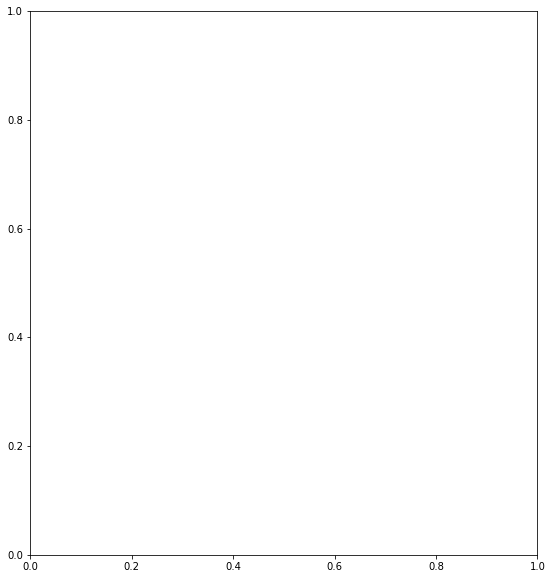

In [6]:
show_gmm(tfidf)

### Теперь отрисуем и посчитаем метрику

In [ ]:
gmm = GaussianMixture(3, covariance_type='full', random_state=42)
gmm_predicted = [gmm.fit_predict(tfidf.todense()), gmm.fit_predict(bag_of_words.todense())]
show_predicted(0, 0, PCA(n_components=2, random_state=42), gmm_predicted, tfidf, bag_of_words)